# 1. Import libraries

In [1]:
# !python -m pip install spacy==2.3.2 -q
# !python -m spacy download pl_core_news_lg

In [2]:
# data manipulation
import numpy as np
import pandas as pd
from collections import Counter
import re
import string

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# nltk
import nltk
nltk.download('wordnet')
import spacy
nlp = spacy.load('pl_core_news_lg')

# feature engineering
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# models
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
import keras
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint

# model evaluation
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, PrecisionRecallDisplay

# settings
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
articles_raw = pd.read_csv('Articles.csv', index_col=0)
articles_raw['Date'] = pd.to_datetime(articles_raw['Date'], format='%Y-%m-%d')
articles_raw

,Date,Title,Content
0,2017-01-02,"DZIEŃ NA GPW: WIG 20 lekko zyskał, w górę posz...",\n Pierwszą sesję w tym roku WI...
1,2017-01-04,Niezatapialna kanclerz. Poprawiają się notowan...,\n Ponad dwa tygodnie po zamachu terror...
2,2017-01-12,Co zrobi Fitch i Moody's? Oto scenariusze dla ...,\n W piątek 13. stycznia dwie wiodące a...
3,2017-01-16,DZIEŃ NA GPW: Po początkowych spadkach indeksy...,\n Indeksy GPW zakończyły ponie...
4,2017-02-02,Nominacja dla Schulza strzałem w dziesiątkę. N...,\n Po nominacji Martina Schulza na kand...
...,...,...,...
1467,2022-01-14,”Moscow Times”: Spadki na giełdzie w Moskwie p...,\n Kurs rubla oraz ceny akcji c...
1468,2022-01-14,Władysław Szczepkowski powołany na p.o. prezes...,\n Rada nadzorcza PKP Cargo del...
1469,2022-01-14,Ropa w USA drożeje już 4 tydzień z rzędu,\n Ropa naftowa w USA nieznaczn...
1470,2022-01-14,Główne indeksy na Wall Street zniżkują,\n Czwartkowa sesja na Wall Str...


In [4]:
articles_raw.isnull().mean()*100

Date       0.0
Title      0.0
Content    0.0
dtype: float64

In [5]:
wig_20_raw = pd.read_csv('WIG_20.csv', index_col=0)
wig_20_raw.rename({'Data': 'Date', 'Zamkniecie': 'Close'}, axis=1, inplace=True)
wig_20_raw['Date'] = pd.to_datetime(wig_20_raw['Date'], format='%Y-%m-%d')
wig_20_raw = wig_20_raw.loc[wig_20_raw['Date']>='2017-01-02', ['Date', 'Close']]
wig_20_raw.reset_index(drop=True, inplace=True)
wig_20_raw

,Date,Close
0,2017-01-02,1956.72
1,2017-01-03,1989.64
2,2017-01-04,1999.93
3,2017-01-05,1998.76
4,2017-01-09,2009.19
...,...,...
1252,2022-01-10,2291.23
1253,2022-01-11,2344.45
1254,2022-01-12,2411.11
1255,2022-01-13,2407.62


# 2. Exploratory Data Analysis

### 2.1 Articles

##### Number of articles per month

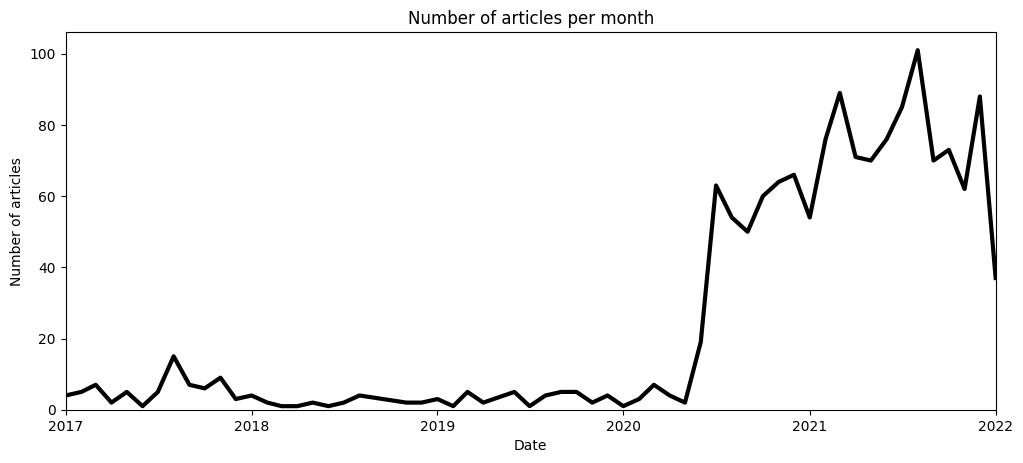

In [6]:
articles_months = articles_raw.copy()
articles_months['Date'] = articles_months["Date"].dt.strftime("%Y-%m")
articles_months = articles_months.groupby(['Date'])[['Date']].count().rename({'Date': 'Count'}, axis=1)
articles_months.index = pd.to_datetime(articles_months.index, format='%Y-%m')
articles_months

plt.figure(figsize=(12, 5), dpi=100)
plt.plot(articles_months['Count'], color='black', linewidth=3)

plt.xlim([articles_months.index.min(), articles_months.index.max()])
plt.ylim([0, articles_months['Count'].max()*1.05])
plt.ylabel('Number of articles')
plt.xlabel('Date')
plt.title('Number of articles per month')
plt.show()

##### Length of articles

In [7]:
articles_raw['Content'].str.len().describe([0.75, 0.9, 0.95])

count     1472.000000
mean      3555.615489
std       2149.881601
min        209.000000
50%       3088.000000
75%       4704.250000
90%       5807.000000
95%       7045.250000
max      17921.000000
Name: Content, dtype: float64

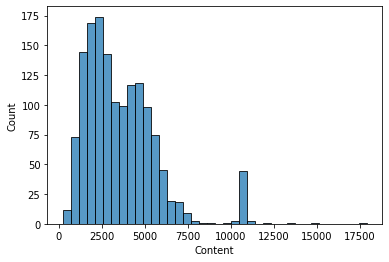

In [8]:
sns.histplot(articles_raw['Content'].str.len())
plt.show()

### 2.2 WIG20

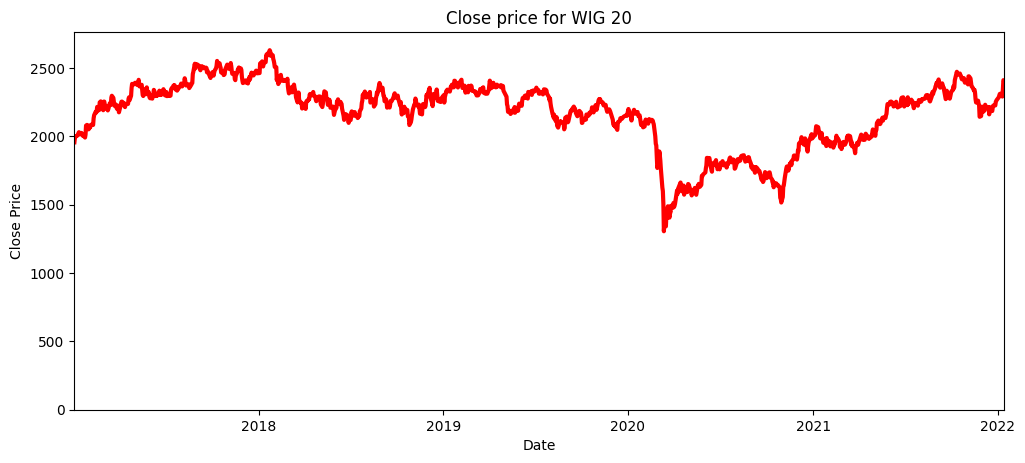

In [9]:
plt.figure(figsize=(12, 5), dpi=100)
plt.plot(wig_20_raw['Date'], wig_20_raw['Close'], color='red', linewidth=3)

plt.xlim([wig_20_raw['Date'].min(), wig_20_raw['Date'].max()])
plt.ylim([0, wig_20_raw['Close'].max()*1.05])
plt.ylabel('Close Price')
plt.xlabel('Date')
plt.title('Close price for WIG 20')
plt.show()

# 3. Data preparation

### 3.1 Mering the data and creating our target (whether the index will increase)

Our model will predict from the article whether the WIG20 will rise (**1**) or not (**0**) in the next month (average 4 weeks). 

In [10]:
wig_20 = wig_20_raw.copy()

# I shift it by 20 working days, of course there is no value for the first days - I am going to remove these days.
wig_20['Increase'] = wig_20['Close'].shift(-20)
wig_20.dropna(inplace=True)

def increase_decrease(row):
    if row['Increase'] > row['Close']:
        return 1
    elif row['Increase'] <= row['Close']:
        return 0

wig_20['Increase'] = wig_20.apply(increase_decrease, axis=1)

# The articles are written daily, so you need to add values for Saturday and Sunday (the exchange does not operate on those days).
wig_20.set_index('Date', inplace=True)
new_dates = pd.date_range(wig_20.index.min(), wig_20.index.max(), freq='d')
wig_20 = wig_20.reindex(new_dates)
wig_20 = wig_20.fillna(method='ffill')
wig_20.reset_index(inplace=True)
wig_20.rename({'index': 'Date'}, axis=1, inplace=True)

wig_20

,Date,Close,Increase
0,2017-01-02,1956.72,1.0
1,2017-01-03,1989.64,1.0
2,2017-01-04,1999.93,1.0
3,2017-01-05,1998.76,1.0
4,2017-01-06,1998.76,1.0
...,...,...,...
1803,2021-12-10,2213.78,1.0
1804,2021-12-11,2213.78,1.0
1805,2021-12-12,2213.78,1.0
1806,2021-12-13,2214.38,1.0


Now we need to check if our classes are balanced:

In [11]:
wig_20['Increase'].value_counts(normalize=True)

1.0    0.563053
0.0    0.436947
Name: Increase, dtype: float64

It's not perfect, but we can assume that the classes are balanced. After merging the data with the articles, we will again need to check if they are balanced as we have different number of articles per month/year.



In [12]:
prepared_dataset = pd.merge(articles_raw, wig_20, on=['Date'], how='inner')
prepared_dataset.set_index('Date', inplace=True)
prepared_dataset = prepared_dataset.loc[: ,['Content', 'Increase']]

prepared_dataset

,Content,Increase
Date,,
2017-01-02,\n Pierwszą sesję w tym roku WI...,1.0
2017-01-04,\n Ponad dwa tygodnie po zamachu terror...,1.0
2017-01-12,\n W piątek 13. stycznia dwie wiodące a...,1.0
2017-01-16,\n Indeksy GPW zakończyły ponie...,1.0
2017-02-02,\n Po nominacji Martina Schulza na kand...,1.0
...,...,...
2021-12-13,\n Miedź na giełdzie metali w L...,1.0
2021-12-13,\n Ropa na giełdzie w Nowym Jor...,1.0
2021-12-14,\n Wtorkowe notowania największ...,1.0


In [13]:
prepared_dataset['Increase'].value_counts(normalize=True)

1.0    0.649388
0.0    0.350612
Name: Increase, dtype: float64

The data is slightly unbalanced - keep that in mind.

### 3.2 N-gram

It is useful to see if there are class-specific words (or phrases). For simplicity, we will skip the lemmatization and text cleaning step.

In [14]:
def ngrams(text, n):
    return [" ".join(x) for x in zip(*[text[i:] for i in range(n)])]

def get_top_ngrams(series, ngrams_range=2, top_n=5):
    all_ngrams = series['Content'].map(lambda x: ngrams(x.strip().lower().split(), ngrams_range)).sum()
    return Counter(all_ngrams).most_common(top_n)

def plot_ngrams(df, labels, ngrams_range, top_n):
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    axes = axes.flatten()

    for i, label in enumerate(labels):
        top_ngrams_freq = get_top_ngrams(df[df['Increase'] == label], ngrams_range=ngrams_range, top_n=top_n)
        top_ngrams = [ngram for ngram, _ in top_ngrams_freq]
        freqs = [freq for _, freq in top_ngrams_freq]
        sns.barplot(x=freqs, y=top_ngrams, ax=axes[i])
        axes[i].set_title(label)

    plt.tight_layout()

###### 3.2.1 Bigrams

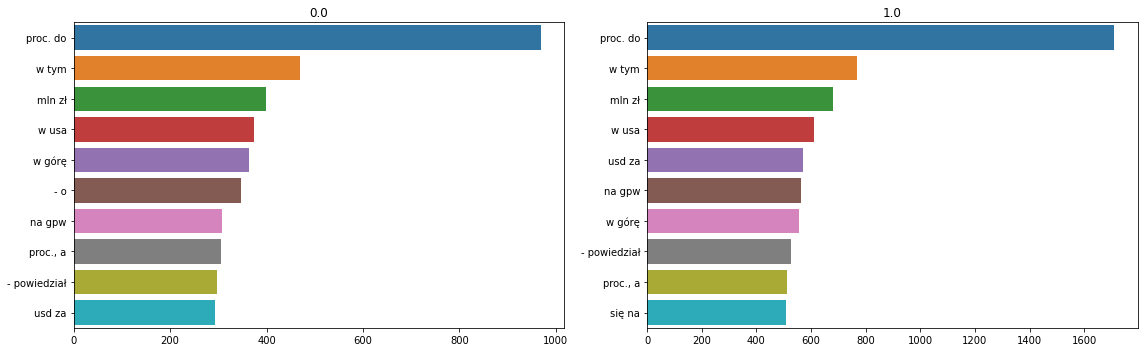

In [15]:
plot_ngrams(prepared_dataset, set(prepared_dataset['Increase']), 2, 10)

###### 3.2.2 Trigrams

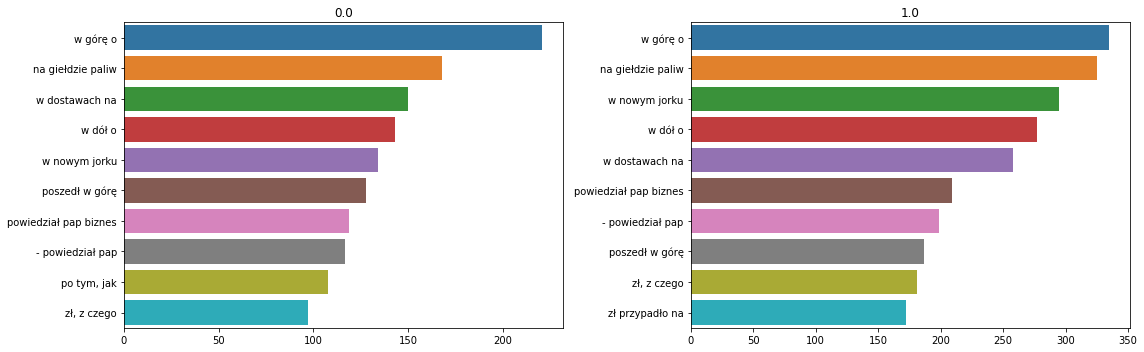

In [16]:
plot_ngrams(prepared_dataset, set(prepared_dataset['Increase']), 3, 10)

It didn't help :)

### 3.3 Cleaning

In [17]:
pl_stopwords = nlp.Defaults.stop_words

In [18]:
punctuations_list = string.punctuation
translator = str.maketrans('', '', punctuations_list) 

In [19]:
def clean_text(text):
    text = text.lower()
    text = re.sub('https?:\/\/[a-zA-Z0-9@:%._\/+~#=?&;-]*', ' ', text)
    text = text.translate(translator)
    text = re.sub(r'(.)1+', r'1', text)
    text = re.sub('\t', '', text)
    text = re.sub('((www.[^s]+)|(https?://[^s]+))',' ', text)
    text = re.sub('[0-9]+', '', text)
    text = ' '.join( [w for w in text.split() if len(w)>1] )
    text = nlp(text)
    text = ' '.join([token.lemma_ for token in text if token.lemma_ not in pl_stopwords])
    return text 

In [20]:
cleaned_dataset = prepared_dataset.copy()
cleaned_dataset['Content'] = cleaned_dataset['Content'].apply(clean_text)
print('Before:')
display(prepared_dataset.head(3))
print('After:')
display(cleaned_dataset.head(3))

Before:


,Content,Increase
Date,,
2017-01-02,\n Pierwszą sesję w tym roku WI...,1.0
2017-01-04,\n Ponad dwa tygodnie po zamachu terror...,1.0
2017-01-12,\n W piątek 13. stycznia dwie wiodące a...,1.0


After:


,Content,Increase
Date,,
2017-01-02,pierwszy sesja rok wig zakończyć lekki plus bl...,1.0
2017-01-04,tydzień zamach terrorystyczny berlina początek...,1.0
2017-01-12,piątka styczeń wieść agencja ratingowy podjąć ...,1.0


In [21]:
prepared_dataset.iloc[0, 0]

'\n                Pierwszą sesję w tym roku WIG 20 zakończył na lekkim plusie. Wśród blue chipów najmocniej wzrosła wycena CCC, po informacji na temat przychodów ze sprzedaży w grudniu. Z kolei notowania LPP poszły w dół po informacjach o sprzedaży hurtowej zapasów, obniżającej marżę.\n         \n\nWIG 20 zakończył sesję na 0,45-proc. plusie i poziomie 1.956,72 pkt. Podobny wzrost zanotował też indeks szerokiego rynku WIG, który wzrósł o 0,3 proc. do 51.907,77 pkt. Spadkiem dzień zakończył z kolei mWIG 40 (-0,36 proc. do 4.200,18 pkt.).\n\n\n\n\n\n\n\nReklama\n\n\nW poniedziałek wiele zagranicznych giełd miało jeszcze dzień wolny. Nie pracują między innymi Brytyjczycy, Szwajcarzy i Amerykanie. Z kolei podczas zamknięcia sesji na GPW niemiecki DAX i francuski CAC szły w górę o kolejno 0,9 proc. i 0,4 proc.\n\n\n\n\n\n\n\nReklama\n\n\n\n\n\n\nObroty na GPW wyniosły prawie 300 mln zł, z czego ok. 187,5 mln zł wygenerowały spółki z WIG 20. Największe obroty na rynku zanotował Bank Pekao (

In [22]:
cleaned_dataset.iloc[0, 0]

'pierwszy sesja rok wig zakończyć lekki plus blue chip mocno wzrość wycena ccc informacja temat przychód sprzedaż grudzień koleja notowanie lpp pójść dół informacja sprzedaż hurtowy zapasy obniżać marża wig zakończyć sesja proc plus poziom pkt podobny wzrost zanotować indeks szeroki rynek wig wzrość proc pkt spadek dzienie zakończyć koleja mwig proc pkt reklama poniedziałek zagraniczny giełda mieć dzienie wolny pracować brytyjczycy szwajcarzy amerykan koleja zamknięcie sesja gpw niemiecki dax francuski cac iść góra kolejno proc proc reklama obrót gpw wynieść mln zł mln zł wygenerować spółka wig wielki obrót rynek zanotować bank pekao mln zł kurs wzrość proc relatywnie duży obrót należeć jsw mln zł pzu mln zł kurs węglowy spółka spaść zamknięcie proc ubezpieczyciel lekko wzrość proc blue chip mocno spaść notowanie lpp spółka poinformować jednorazowy transakcja hurtowy sprzedaż zapasy stary kolekcja skutek marża brutto sprzedaż grudniowy obniżyć poziom proc lpp podać jednocześnie przychó

### 3.4 Tag Cloud

In [23]:
cleaned_dataset.Content = cleaned_dataset.Content.astype(str)
cleaned_dataset

,Content,Increase
Date,,
2017-01-02,pierwszy sesja rok wig zakończyć lekki plus bl...,1.0
2017-01-04,tydzień zamach terrorystyczny berlina początek...,1.0
2017-01-12,piątka styczeń wieść agencja ratingowy podjąć ...,1.0
2017-01-16,indeks gpw zakończyć poniedziałkowy notowanie ...,1.0
2017-02-02,nominacja martina schulza kandydat kanclerz ni...,1.0
...,...,...
2021-12-13,miedź giełda metal londynie drożeć reakcja poz...,1.0
2021-12-13,ropa giełda nowy jorku drożeć ubiegły tydzień ...,1.0
2021-12-14,wtorkowy notowanie wielki krajowy spółka przeb...,1.0


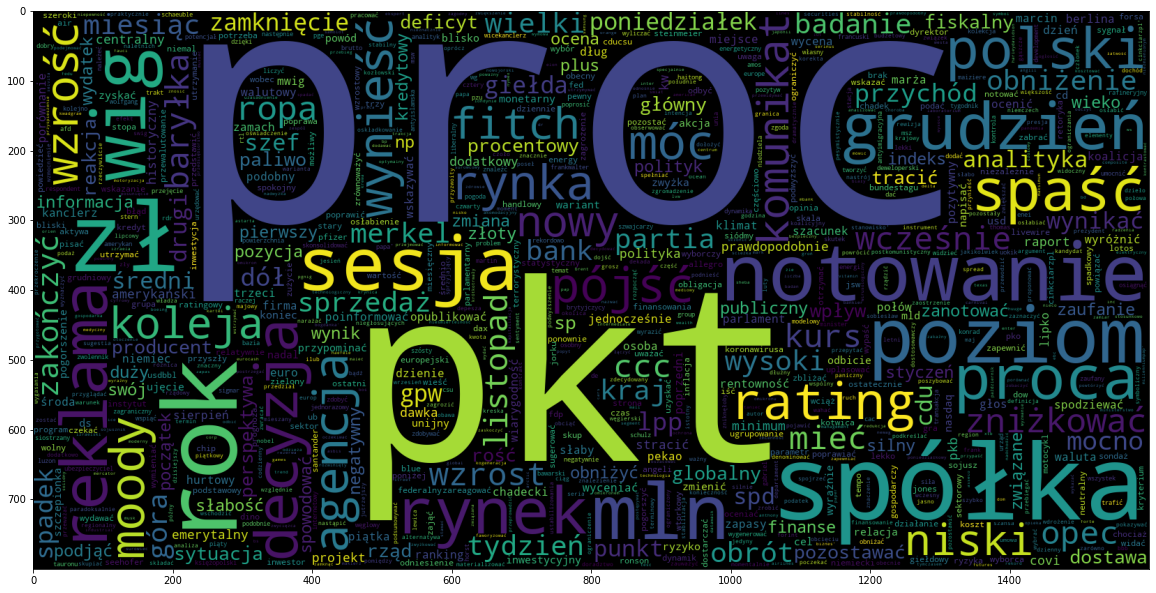

In [24]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(str(cleaned_dataset.Content.values))
plt.imshow(wc)

### 3.5 Train Test Split

In [25]:
first_test_date = pd.datetime.strptime('2021-07-01', '%Y-%m-%d')

print('Train dataset:')
train_dataset = cleaned_dataset.loc[cleaned_dataset.index<first_test_date, :].copy()
print(train_dataset['Increase'].value_counts(normalize=True))
display(train_dataset)

print('Test dataset:')
test_dataset = cleaned_dataset.loc[cleaned_dataset.index>=first_test_date, :].copy()
print(test_dataset['Increase'].value_counts(normalize=True))
display(test_dataset)

Train dataset:
1.0    0.646444
0.0    0.353556
Name: Increase, dtype: float64


,Content,Increase
Date,,
2017-01-02,pierwszy sesja rok wig zakończyć lekki plus bl...,1.0
2017-01-04,tydzień zamach terrorystyczny berlina początek...,1.0
2017-01-12,piątka styczeń wieść agencja ratingowy podjąć ...,1.0
2017-01-16,indeks gpw zakończyć poniedziałkowy notowanie ...,1.0
2017-02-02,nominacja martina schulza kandydat kanclerz ni...,1.0
...,...,...
2021-06-30,pandemia wywrzeć niespotykany dotąd wpływ dzia...,1.0
2021-06-30,wydarzenie środa rodzimy rynek walutowy publik...,1.0
2021-06-30,ropa giełda paliwo nowy jorku drożeć kończyć p...,1.0


Test dataset:
1.0    0.655889
0.0    0.344111
Name: Increase, dtype: float64


,Content,Increase
Date,,
2021-07-01,główny indeks gpw czwartka odbić mocny środowy...,1.0
2021-07-02,nadchodzić tydzień odbyć posiedzenie rada poli...,1.0
2021-07-02,jw construction holding złożyć wniosek komisja...,1.0
2021-07-02,miedź giełda metal londynie tanieć reakcja spa...,1.0
2021-07-02,ropa giełda paliwo nowy jorku trzymać poziom u...,1.0
...,...,...
2021-12-13,miedź giełda metal londynie drożeć reakcja poz...,1.0
2021-12-13,ropa giełda nowy jorku drożeć ubiegły tydzień ...,1.0
2021-12-14,wtorkowy notowanie wielki krajowy spółka przeb...,1.0


In [26]:
X_train = train_dataset.Content
y_train = train_dataset.Increase

X_test = test_dataset.Content
y_test = test_dataset.Increase

# 4. Modelling and Evaluation

The task is an exploration of the methods using in NLP, so we will not focus on the selection of hyperparameters.

In [27]:
def model_Evaluate(model, X_test_set, y_test_set):
    # Data prediction on test data
    y_pred = model.predict(X_test_set)

    # Display evaluation metrics based on prediction and ground truth (actual labels)
    print(classification_report(y_test_set, y_pred))

    # We calculate and display the confusion matrix
    cf_matrix = confusion_matrix(y_test_set, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '', xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC CURVE')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall
    PrecisionRecallDisplay.from_predictions(y_test, y_pred)
    plt.title('Precision-Recall')
    plt.show()

### 4.1. Simple ML model

##### 4.1.1 Vectorization of words using the tool TF-IDF Vectorizer

In [28]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectorizer.fit(X_train)
print('No. of feature_words: ', len(vectorizer.get_feature_names()))

No. of feature_words:  146528


In [29]:
X_train_vectorizer = vectorizer.transform(X_train)
X_test_vectorizer  = vectorizer.transform(X_test)

##### 4.1.2 Train and Evaluate model

4.1.2.1 Naive Bayes - Bernoulli

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       149
         1.0       0.66      1.00      0.79       284

    accuracy                           0.66       433
   macro avg       0.33      0.50      0.40       433
weighted avg       0.43      0.66      0.52       433



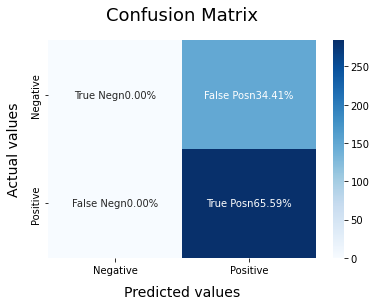

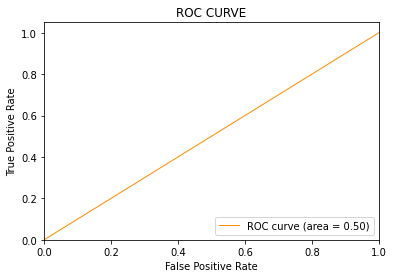

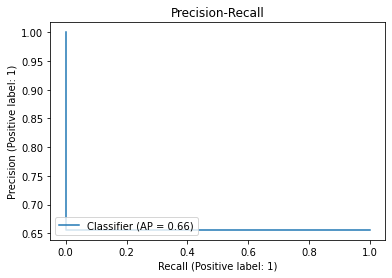

In [30]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train_vectorizer, y_train)
model_Evaluate(BNBmodel, X_test_vectorizer, y_test)

4.1.2.2 Logistic Regression

              precision    recall  f1-score   support

         0.0       0.17      0.01      0.01       149
         1.0       0.65      0.98      0.78       284

    accuracy                           0.65       433
   macro avg       0.41      0.49      0.40       433
weighted avg       0.49      0.65      0.52       433



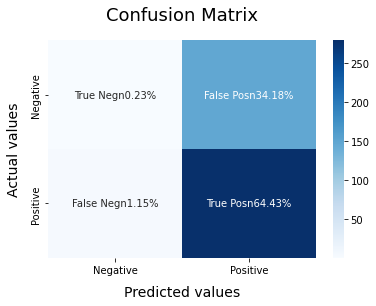

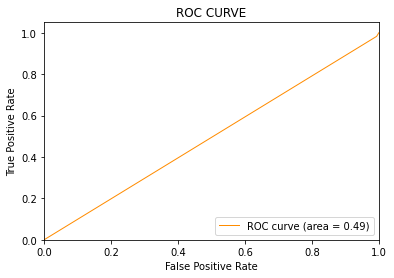

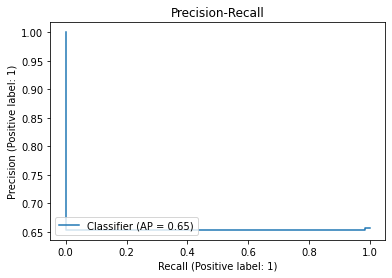

In [31]:
LRmodel = LogisticRegression(max_iter = 1000)
LRmodel.fit(X_train_vectorizer, y_train)
model_Evaluate(LRmodel, X_test_vectorizer, y_test)

4.1.2.3 Random Forest



              precision    recall  f1-score   support

         0.0       0.12      0.01      0.01       149
         1.0       0.65      0.98      0.78       284

    accuracy                           0.64       433
   macro avg       0.39      0.49      0.40       433
weighted avg       0.47      0.64      0.52       433



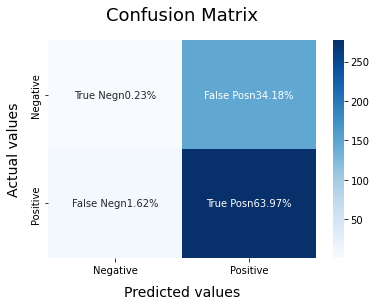

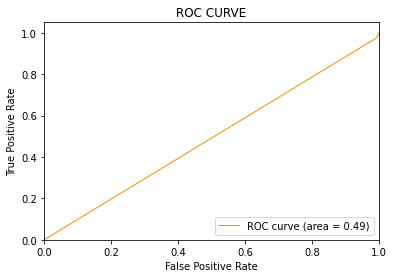

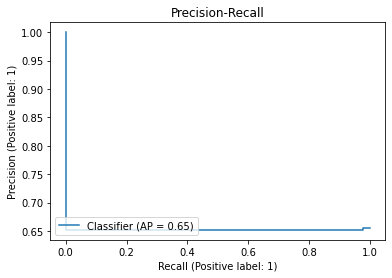

In [32]:
RFmodel = RandomForestClassifier(n_estimators=1000)
RFmodel.fit(X_train_vectorizer, y_train)
model_Evaluate(RFmodel, X_test_vectorizer, y_test)

### 4. 2 NN

##### 4.2.1 Converting text to tensors

In [33]:
max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_tensor = tokenizer.texts_to_sequences(X_train)
X_train_tensor = pad_sequences(X_train_tensor, maxlen=max_len)
print('Train Shape')
print(f'X: {X_train_tensor.shape}')
print(f'y: {y_train.shape}')

X_test_tensor = tokenizer.texts_to_sequences(X_test)
X_test_tensor = pad_sequences(X_test_tensor, maxlen=max_len)
print('\nTest Shape')
print(f'X: {X_test_tensor.shape}')
print(f'y: {y_test.shape}')

Train Shape
X: (956, 200)
y: (956,)

Test Shape
X: (433, 200)
y: (433,)


##### 4.2.2 Train model

In [34]:
model_nn = Sequential()
model_nn.add(layers.Embedding(max_words, 20))
model_nn.add(layers.LSTM(15,dropout=0.5))
model_nn.add(layers.Dense(1, activation='softmax'))


model_nn.compile(optimizer='rmsprop',
                 loss='categorical_crossentropy', 
                 metrics=['accuracy'])


checkpoint1 = ModelCheckpoint("best_model1.hdf5", 
                              monitor='val_accuracy',
                              save_best_only=True,
                              mode='auto',
                              save_weights_only=False)

history = model_nn.fit(X_train_tensor, 
                       y_train, 
                       epochs=70,
                       validation_data=(X_test_tensor, y_test),
                       callbacks=[checkpoint1])

Epoch 1/70
30/30 [==============================] - 6s 34ms/step - loss: 0.0000e+00 - accuracy: 0.6464 - val_loss: 0.0000e+00 - val_accuracy: 0.6559
Epoch 2/70
30/30 [==============================] - 0s 12ms/step - loss: 0.0000e+00 - accuracy: 0.6464 - val_loss: 0.0000e+00 - val_accuracy: 0.6559
Epoch 3/70
30/30 [==============================] - 0s 12ms/step - loss: 0.0000e+00 - accuracy: 0.6464 - val_loss: 0.0000e+00 - val_accuracy: 0.6559
Epoch 4/70
30/30 [==============================] - 0s 12ms/step - loss: 0.0000e+00 - accuracy: 0.6464 - val_loss: 0.0000e+00 - val_accuracy: 0.6559
Epoch 5/70
30/30 [==============================] - 0s 12ms/step - loss: 0.0000e+00 - accuracy: 0.6464 - val_loss: 0.0000e+00 - val_accuracy: 0.6559
Epoch 6/70
30/30 [==============================] - 0s 12ms/step - loss: 0.0000e+00 - accuracy: 0.6464 - val_loss: 0.0000e+00 - val_accuracy: 0.6559
Epoch 7/70
30/30 [==============================] - 0s 12ms/step - loss: 0.0000e+00 - accuracy: 0.6464 - v

### 4.3 BERT